# **IMPORT LIBRARIES**

In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **IMPORT DATA, TEST/TRAIN SPLIT, SCALE**

In [2]:
features = pd.read_csv("../data/paris_lille/geometric_features.csv")

X = features.drop(['class'], axis=1)
y = features[['class']].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y)

# **BASELINE GAUSSIAN PROCESS CLASSIFIER**

In [3]:
gp_model = GaussianProcessClassifier()
gp_model.fit(X_train, y_train)
y_pred = gp_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      0.727     0.471     0.571        17
           Bench      1.000     0.500     0.667         2
    Bicycle Rack      0.600     0.600     0.600         5
Bicycle Terminal      0.857     0.857     0.857         7
         Bollard      0.838     0.814     0.826        70
        Building      0.000     0.000     0.000        17
           Chair      0.667     1.000     0.800         2
Distribution Box      1.000     0.500     0.667         2
      Floor Lamp      0.900     0.900     0.900        20
          Island      1.000     0.200     0.333         5
Lighting Console      0.838     0.816     0.827        38
        Low Wall      0.750     0.632     0.686        19
      Mobile Car      0.444     0.500     0.471         8
  Mobile Scooter      0.000     0.000     0.000         1
      Mobile Van      1.000     1.000     1.000         1
         Natural      0.917     0.917     0.917        60
  Parked Bicy

# **HYPERPARAMETER TUNING**

In [4]:
model = GaussianProcessClassifier()

params_grid = dict()
params_grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
grid_search = GridSearchCV(estimator=model, n_jobs=-1, cv=cv, param_grid=params_grid, scoring='f1_micro')
search_results = grid_search.fit(X_train, y_train)

In [6]:
search_results.best_estimator_

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1))

In [7]:
best_model = search_results.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
print(f1_score(y_test, y_pred, average='micro'))

                  precision    recall  f1-score   support

         Barrier      0.750     0.529     0.621        17
           Bench      0.000     0.000     0.000         2
    Bicycle Rack      1.000     0.600     0.750         5
Bicycle Terminal      1.000     1.000     1.000         7
         Bollard      0.899     0.886     0.892        70
        Building      1.000     0.353     0.522        17
           Chair      0.067     1.000     0.125         2
Distribution Box      0.500     0.500     0.500         2
      Floor Lamp      0.488     1.000     0.656        20
          Island      1.000     0.200     0.333         5
Lighting Console      0.970     0.842     0.901        38
        Low Wall      0.706     0.632     0.667        19
      Mobile Car      0.571     0.500     0.533         8
  Mobile Scooter      0.000     0.000     0.000         1
      Mobile Van      1.000     1.000     1.000         1
         Natural      0.889     0.933     0.911        60
  Parked Bicy

# **CONFUSION MATRIX**

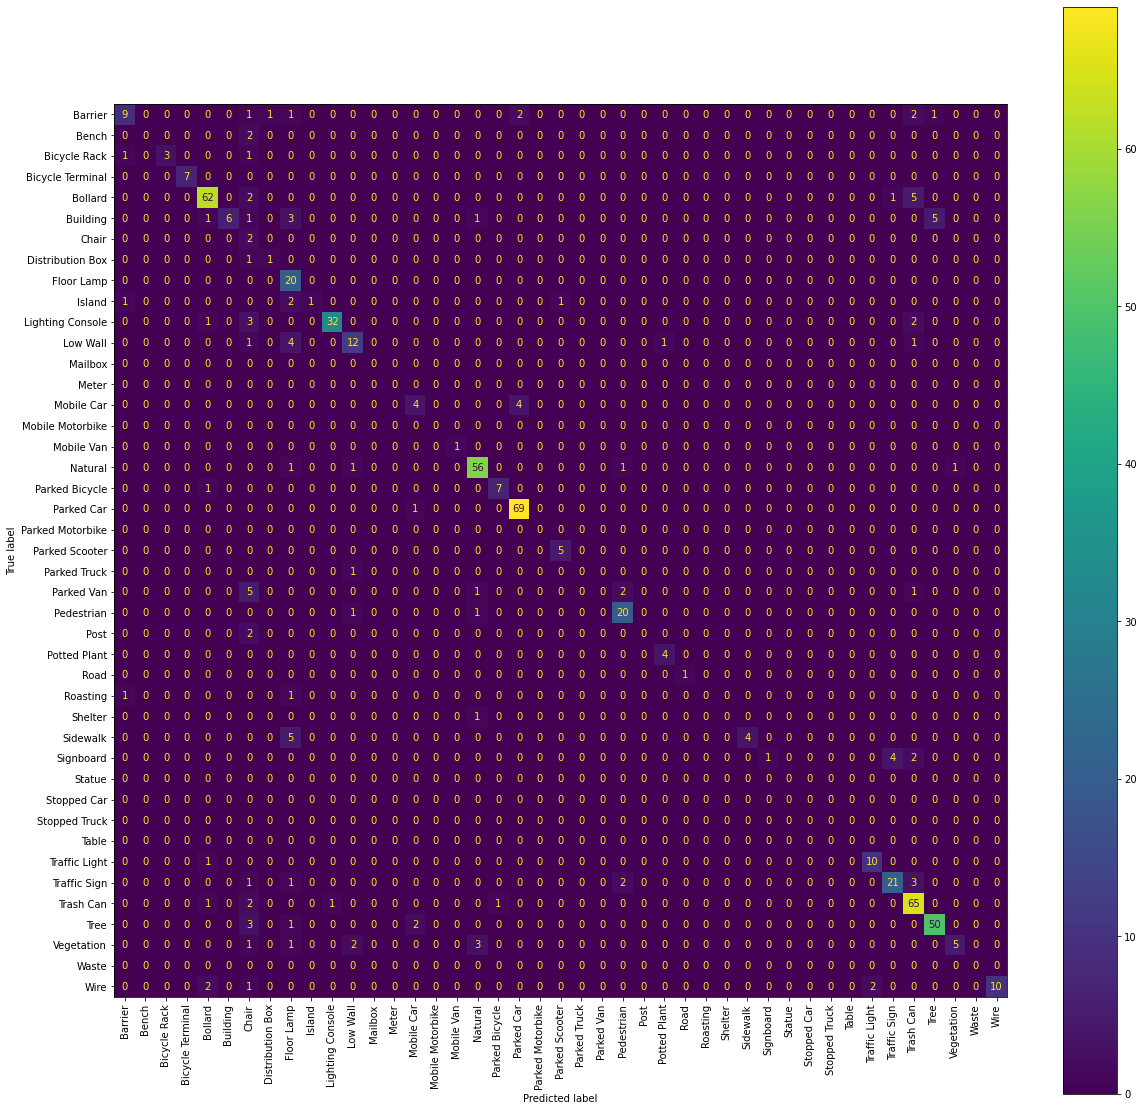

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cmd.plot(ax=ax, xticks_rotation='vertical');

plt.savefig('confusionmatrix_gaussianprocess.png', dpi=600)

# **FEATURE IMPORTANCE**

In [9]:
results = permutation_importance(best_model, X_test, y_test, scoring='f1_micro')
importance = results.importances_mean
for i,v in enumerate(importance):
    print('Feature: %0d, Score %.5f' % (i,v))

Feature: 0, Score 0.09082
Feature: 1, Score 0.02918
Feature: 2, Score 0.21738
Feature: 3, Score 0.08656
Feature: 4, Score 0.05213
Feature: 5, Score 0.14393
Feature: 6, Score 0.09082
Feature: 7, Score 0.38066
Feature: 8, Score 0.51836


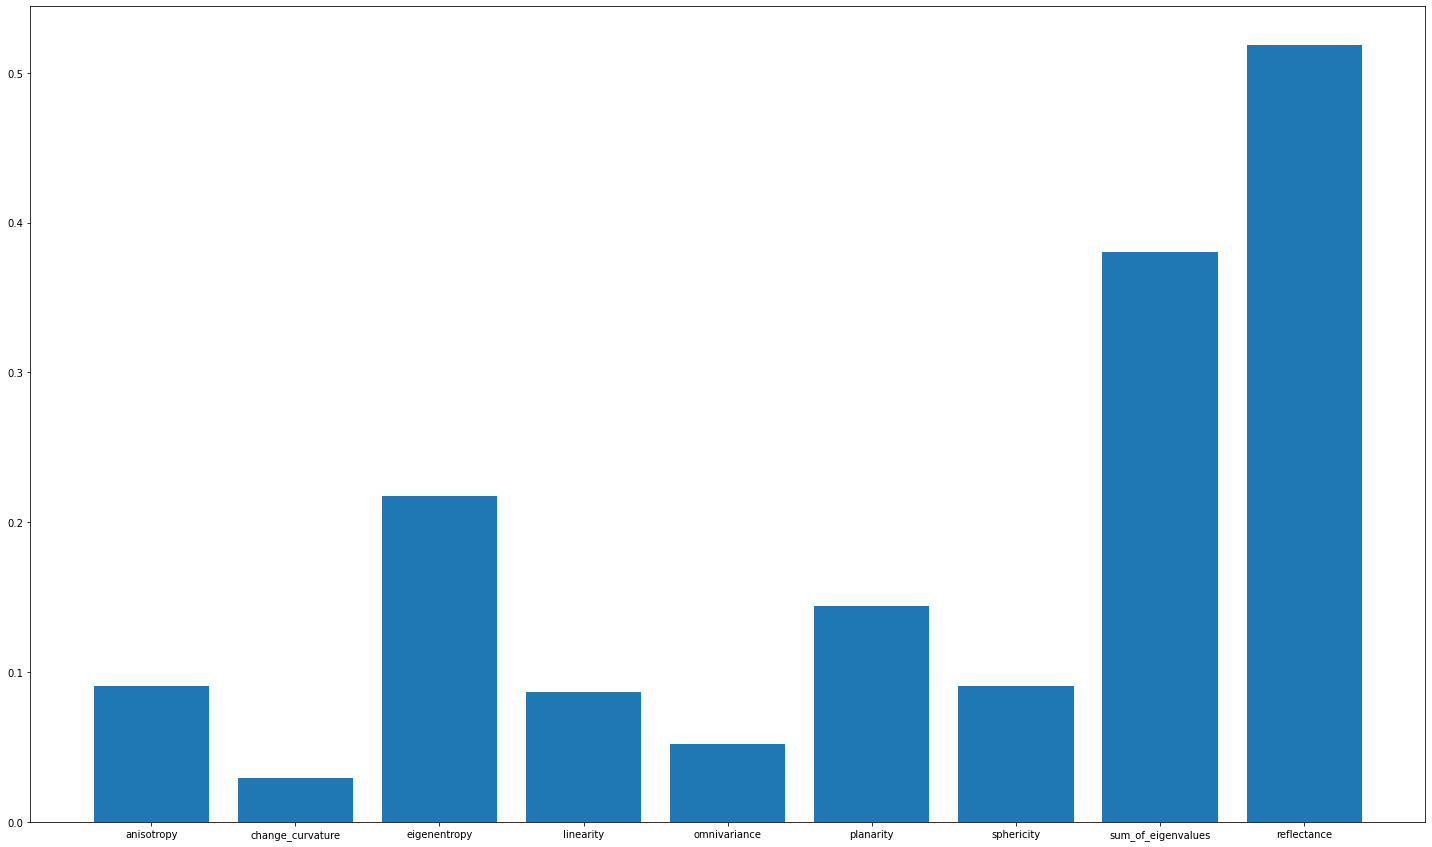

In [10]:
plt.figure(figsize=(25,15))
plt.bar(range(len(results.importances_mean)), results.importances_mean)
plt.xticks(range(len(results.importances_mean)), X.columns)
plt.savefig('featureimportance_gaussianprocess.png', dpi=600)
plt.show()